# Deep Learning Project Work  
<a href="https://colab.research.google.com/drive/1nhM6PHPUmkrGG0BHGnQorfqnzRiScf2M">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Source material: https://github.com/plutoyuxie/AutoEncoder-SSIM-for-unsupervised-anomaly-detection-

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# 1. Data acquisition, pre-processing and visualization

## 1.1 Downloading data

In [ ]:
# Downloading data from the MVTecAD database - Carpet and Hazelnut categories were used

!wget https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937545-1629951845/hazelnut.tar.xz
!wget https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937484-1629951672/carpet.tar.xz
!tar -xf hazelnut.tar.xz 
!tar -xf carpet.tar.xz

--2022-12-11 10:22:42--  https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937545-1629951845/hazelnut.tar.xz
Resolving www.mydrive.ch (www.mydrive.ch)... 91.214.169.64
Connecting to www.mydrive.ch (www.mydrive.ch)|91.214.169.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 617098680 (589M) [application/x-xz]
Saving to: ‘hazelnut.tar.xz’

hazelnut.tar.xz     100%[===================>] 588.51M  15.7MB/s    in 39s     

2022-12-11 10:23:23 (15.0 MB/s) - ‘hazelnut.tar.xz’ saved [617098680/617098680]

--2022-12-11 10:23:24--  https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937484-1629951672/carpet.tar.xz
Resolving www.mydrive.ch (www.mydrive.ch)... 91.214.169.64
Connecting to www.mydrive.ch (www.mydrive.ch)|91.214.169.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 740285760 (706M) [application/x-xz]
Saving to: ‘carpet.tar.xz’

carpet.tar.xz       100%[===================

## 1.2 Input pipeline with augmentation

In [ ]:
import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Defining desired parameters
image_size = 256
batch_size = 128

# Creating distinct data generators for training (+val) and test data
# As for pre-processing we only normalize our images for the test set, but apply some augmentation on the train and val sets
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.2, vertical_flip=True, horizontal_flip=True, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/kaggle/working/hazelnut/train/',
        target_size=(image_size,image_size),
        batch_size=batch_size,
        class_mode='input',
        subset='training',
        seed=42)

validation_generator = train_datagen.flow_from_directory(
        '/kaggle/working/hazelnut/train/',
        target_size=(image_size,image_size),
        batch_size=batch_size,
        class_mode='input',
        subset='validation',
        seed=42)

test_generator = test_datagen.flow_from_directory(
        '/kaggle/working/hazelnut/test',
        target_size=(image_size,image_size),
        batch_size=batch_size,
        class_mode='input',
        shuffle=False,
        seed=42)

Found 313 images belonging to 1 classes.
Found 78 images belonging to 1 classes.
Found 110 images belonging to 5 classes.


## 1.3 Train-val-test visualization

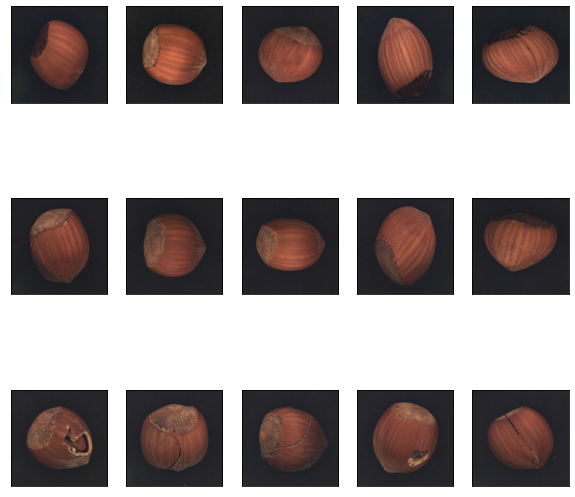

In [ ]:
# Visualize some images from the train - validation - test dataset
# We can see, that the augmetation has taken place in case of
# the training and validation datasets
def plot_train_val_test():

    n = 5
    plt.figure(figsize=(10, 10))
    for i in range(1, n+1):

        ax = plt.subplot(3, 5, i)
        plt.imshow(train_generator[0][0][i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, 5, i+5)
        plt.imshow(validation_generator[0][0][i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, 5, i+10)
        plt.imshow(test_generator[0][0][i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plot_train_val_test()

# 2. Model

## 2.1 Architecture (Convolutional Autoencoder)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Input, LeakyReLU
from tensorflow.keras.models import Model

filters = 32
latent_dim = 500    # bottleneck size
input_channel = 3   # since we want RGB images as a result

input_img = Input(shape=((image_size,image_size,input_channel)))

h = Conv2D(filters, (4, 4), strides=2, activation=LeakyReLU(alpha=0.2), padding='same')(input_img)
h = Conv2D(filters, (4, 4), strides=2, activation=LeakyReLU(alpha=0.2), padding='same')(h)
# h = Conv2D(filters, (4, 4), strides=2, activation=LeakyReLU(alpha=0.2), padding='same')(h)
h = Conv2D(filters, (3, 3), strides=1, activation=LeakyReLU(alpha=0.2), padding='same')(h)
h = Conv2D(filters*2, (4, 4), strides=2, activation=LeakyReLU(alpha=0.2), padding='same')(h)
h = Conv2D(filters*2, (3, 3), strides=1, activation=LeakyReLU(alpha=0.2), padding='same')(h)
h = Conv2D(filters*4, (4, 4), strides=2, activation=LeakyReLU(alpha=0.2), padding='same')(h)
h = Conv2D(filters*2, (3, 3), strides=1, activation=LeakyReLU(alpha=0.2), padding='same')(h)
h = Conv2D(filters, (3, 3), strides=1, activation=LeakyReLU(alpha=0.2), padding='same')(h)
encoded = Conv2D(latent_dim, (3, 3), strides=1, activation='linear', padding='valid')(h)

h = Conv2DTranspose(filters, (3, 3), strides=1, activation=LeakyReLU(alpha=0.2), padding='valid')(encoded)
h = Conv2D(filters*2, (3, 3), strides=1, activation=LeakyReLU(alpha=0.2), padding='same')(h)
h = Conv2D(filters*4, (3, 3), strides=1, activation=LeakyReLU(alpha=0.2), padding='same')(h)
h = Conv2DTranspose(filters*2, (4, 4), strides=2, activation=LeakyReLU(alpha=0.2), padding='same')(h)
h = Conv2D(filters*2, (3, 3), strides=1, activation=LeakyReLU(alpha=0.2), padding='same')(h)
h = Conv2DTranspose(filters, (4, 4), strides=2, activation=LeakyReLU(alpha=0.2), padding='same')(h)
h = Conv2D(filters, (3, 3), strides=1, activation=LeakyReLU(alpha=0.2), padding='same')(h)
h = Conv2DTranspose(filters, (4, 4), strides=2, activation=LeakyReLU(alpha=0.2), padding='same')(h)
# h = Conv2DTranspose(filters, (4, 4), strides=2, activation=LeakyReLU(alpha=0.2), padding='same')(h)
decoded = Conv2DTranspose(input_channel, (4, 4), strides=2, activation='sigmoid', padding='same')(h)

autoencoder = Model(input_img, decoded)
# autoencoder.summary()

2022-12-11 10:24:44.563951: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## 2.2 Loss, Callbacks

In [ ]:
# Defining custom SSIM loss function
# the "original" SSIM was meant to be used on grayscale images, but this one
# can operate with RGB images
#@tf.function
def ssim_loss(gt, y_pred, max_val=1.0):
    return 1 - tf.reduce_mean(tf.image.ssim_multiscale(gt, y_pred, max_val=max_val))

loss = ssim_loss


# Defining callbacks
import tensorflow.image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam

lr = 2e-4
decay = 1e-5
optimizer = Adam(lr=lr, decay=decay)
autoencoder.compile(optimizer=optimizer, loss=loss, metrics=['mse'])


earlystopping = EarlyStopping(patience=20, verbose=1)
checkpoint = ModelCheckpoint(filepath='/kaggle/working/model.hdf5', save_best_only=True, period=1, mode='auto', verbose=1, save_weights_only=True)
tb = TensorBoard(log_dir='/kaggle/working/tmp/autoencoder', histogram_freq=1, write_graph=1)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
2022-12-11 10:43:40.756585: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-11 10:43:40.756706: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-12-11 10:43:40.756834: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


## 2.3 Metrics visualization

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=/content/tmp/autoencoder

We can see, that our metrics are consistently decreasing as the training/learning progresses - Mean Squared Error and SSIM loss values are getting smaller and smaller

# 3. Training

In [ ]:
epochs = 1000
network_history = autoencoder.fit(train_generator, epochs=epochs, validation_data=validation_generator, verbose=1, callbacks=[checkpoint, earlystopping, tb])

2022-12-08 20:06:04.154982: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/1000


2022-12-08 20:06:13.071230: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1/3 [=========>....................] - ETA: 42s - loss: 0.4327 - mse: 0.1037

2022-12-08 20:06:25.759767: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-08 20:06:25.759819: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


2/3 [===================>..........] - ETA: 4s - loss: 0.4392 - mse: 0.1035 

2022-12-08 20:06:29.701320: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-08 20:06:29.708048: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-12-08 20:06:29.895747: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 8173 callback api events and 6926 activity events. 
2022-12-08 20:06:30.041264: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-08 20:06:30.325418: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /kaggle/working/tmp/autoencoder/train/plugins/profile/2022_12_08_20_06_30

2022-12-08 20:06:30.480749: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /kaggle/working/tmp/autoencoder/train/plugins/profile/2022_12_08_20_06_30/934b6a98af69.trace.json.gz
2022-12-08 20:06:30.663691: I tensorflow/core/profiler/rpc/client/

3/3 [==============================] - 42s 11s/step - loss: 0.4419 - mse: 0.1036 - val_loss: 0.4212 - val_mse: 0.1071

Epoch 00001: val_loss improved from inf to 0.42120, saving model to /kaggle/working/model.hdf5
Epoch 2/1000
3/3 [==============================] - 24s 10s/step - loss: 0.4412 - mse: 0.1037 - val_loss: 0.4212 - val_mse: 0.1063

Epoch 00002: val_loss did not improve from 0.42120
Epoch 3/1000
3/3 [==============================] - 24s 10s/step - loss: 0.4416 - mse: 0.1036 - val_loss: 0.4201 - val_mse: 0.1063

Epoch 00003: val_loss improved from 0.42120 to 0.42012, saving model to /kaggle/working/model.hdf5
Epoch 4/1000
3/3 [==============================] - 24s 8s/step - loss: 0.4410 - mse: 0.1034 - val_loss: 0.4203 - val_mse: 0.1065

Epoch 00004: val_loss did not improve from 0.42012
Epoch 5/1000
3/3 [==============================] - 23s 8s/step - loss: 0.4408 - mse: 0.1035 - val_loss: 0.4191 - val_mse: 0.1061

Epoch 00005: val_loss improved from 0.42012 to 0.41910, sav

## 3.2 Evaluation

(78, 256, 256, 3) (78, 256, 256, 3)


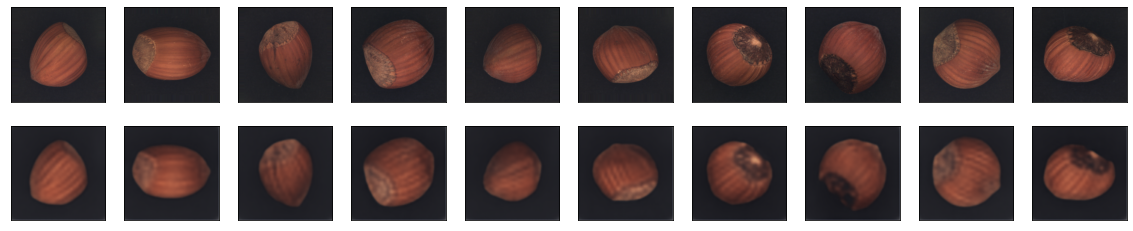

In [ ]:
# Getting the next batch from the validation generator and visualizing the results
val_imgs = next(validation_generator)

val_pred = autoencoder.predict(val_imgs[0])

print(val_pred.shape, val_imgs[0].shape)

# Plotting reconstructed images
def plot_val_predict(val_pred, val_imgs):

    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(1, n+1):

        # Displaying original
        ax = plt.subplot(2, n, i)
        plt.imshow(val_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Displaying reconstruction
        ax = plt.subplot(2, n, i + n)
        plt.imshow(val_pred[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

plot_val_predict(val_pred, val_imgs[0])

In the bottom row the original images of the validation dataset can be seen, and on the bottom row their reconstructed counterparts are shown. Our model made fairly good predictions on the validation dataset - even with the zooming and flipping applied onto the original dataset. We had high hopes for the anomaly detection/segmentation tasks

# 4. Testing

In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage import morphology
from tensorflow.keras.models import load_model

autoencoder.load_weights('/kaggle/working/model.hdf5')

# Predicting test images
decoded_img = autoencoder.predict(test_generator)
print(decoded_img.shape)

# Getting "original" test images from generator
images = next(test_generator)
print(images[0].shape)

2022-12-11 10:25:20.253458: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(110, 256, 256, 3)
(110, 256, 256, 3)


In [ ]:
def get_residual_map(img, dec_img):
    # Reconstructed image
    rec_img = np.reshape((dec_img * 255.).astype('uint8'), (256,256,3))
    
    ssim_residual_map = ssim(img, rec_img, win_size=11, full=True, multichannel=True)[1]    
    ssim_residual_map = 1 - np.mean(ssim_residual_map, axis=2)
    l1_residual_map = np.mean(np.abs(img / 255. - rec_img / 255.), axis=2)

    return img, rec_img, ssim_residual_map, l1_residual_map

# Calculating threshold for distinction between normal images and images with some anomalies on them
def get_threshold(images, decoded_img):

  print('Estimating threshold...')
  percent = 98.0
  total_rec_ssim, total_rec_l1 = [], []

  # Calculating threshold from the test images
  for i in range(len(images[0])):
      _, _, ssim_residual_map, l1_residual_map = get_residual_map(images[0][i], decoded_img[i])
      total_rec_ssim.append(ssim_residual_map)
      total_rec_l1.append(l1_residual_map)

  total_rec_ssim = np.array(total_rec_ssim)
  total_rec_l1 = np.array(total_rec_l1)

  ssim_threshold = float(np.percentile(total_rec_ssim, [percent]))
  l1_threshold = float(np.percentile(total_rec_l1, [percent]))

  print('ssim_threshold: %f, l1_threshold: %f' %(ssim_threshold, l1_threshold))
  return ssim_threshold, l1_threshold


# After we got our threshold values, we create and apply a mask based on it
# Those parts/pixels of the images, which were deemed to be containing some 
# anomalies (=they were above the treshold) will get under this mask
def get_depressing_mask():

    mask_size = 256
    depr_mask = np.ones((mask_size, mask_size)) * 0.2
    depr_mask[5:mask_size-5, 5:mask_size-5] = 1
    return depr_mask

def bg_mask(img, value):

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.astype('uint8')
    _,thresh=cv2.threshold(img,value,255,cv2.THRESH_BINARY)

    def FillHole(mask):

        contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        len_contour = len(contours)
        contour_list = []

        for i in range(len_contour):
            drawing = np.zeros_like(mask, np.uint8)  # create a black image
            img_contour = cv2.drawContours(drawing, contours, i, (255, 255, 255), -1)
            contour_list.append(img_contour)

        out = sum(contour_list)
        return out

    thresh = FillHole(thresh)
    if type(thresh) is int:
        return np.ones(img.shape)
    mask_ = np.ones(thresh.shape)
    mask_[np.where(thresh <= 127)] = 0
    return mask_


# Based on the previously calculated values, the segmentation masks are applied to the test images
def get_results(depression_mask, ssim_threshold, l1_threshold, images, decoded_img):

    mask_, test_img_, rec_img_, vis_img_ = [], [], [], []
    
    for i in range(len(images[0])-4):

        test_img, rec_img, ssim_residual_map, l1_residual_map = get_residual_map(images[0][i], decoded_img[i])

        ssim_residual_map *= depression_mask
        l1_residual_map *= depression_mask

        mask_size = 256
        mask = np.zeros((mask_size, mask_size))
        mask[ssim_residual_map > ssim_threshold] = 1
        mask[l1_residual_map > l1_threshold] = 1

        copyss = test_img.copy()
        bg_m = bg_mask(copyss, 50)
        mask *= bg_m

        kernel = morphology.disk(4)
        mask = morphology.opening(mask, kernel)
        mask *= 255

        vis_img = set_img_color(test_img.copy(), mask, weight_foreground=0.3)
        
        mask_.append(mask)
        test_img_.append(test_img)
        rec_img_.append(rec_img)
        vis_img_.append(vis_img)
        
    return mask_, test_img_, rec_img_, vis_img_
        
def set_img_color(img, predict_mask, weight_foreground):

    origin = img
    img[np.where(predict_mask == 255)] = (0,0,255)
    cv2.addWeighted(img, weight_foreground, origin, (1 - weight_foreground), 0, img)
    return img

def plot_reconstructed(mask_, test_img_, rec_img_, vis_img_):
    
    n = 4 
    plt.figure(figsize=(8, 8))
    for i in range(1, n+1):

        idx = np.random.randint(low=0, high=len(mask_)-1)

        ax = plt.subplot(4, 4, i)
        plt.imshow(mask_[idx])
        plt.gray()
        plt.title('mask')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(4, 4, i+4)
        plt.imshow(test_img_[idx])
        plt.gray()
        plt.title('test_img')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(4, 4, i+8)
        plt.imshow(rec_img_[idx])
        plt.gray()
        plt.title('rec_img')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(4, 4, i+12)
        plt.imshow(vis_img_[idx])
        plt.gray()
        plt.title('vis_img')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## 4.1 Calculating SSIM threshold and L1 treshold + Evaluation + some visualization

Estimating threshold...


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  """


ssim_threshold: 1.000001, l1_threshold: 0.434987
1/1 [==============================] - 9s 9s/step - loss: 0.0550 - mse: 0.0012


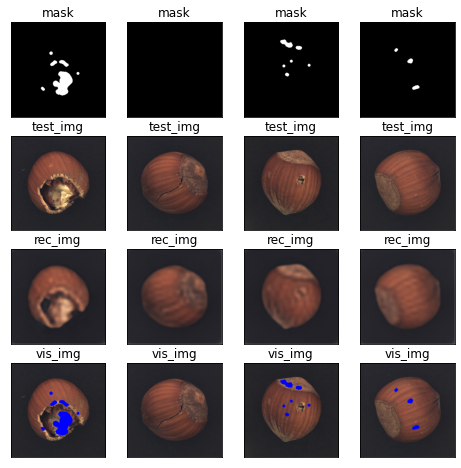

In [ ]:
ssim_threshold, l1_threshold = get_threshold(images, decoded_img)
depressing_mask = get_depressing_mask()
mask_, test_img_, rec_img_, vis_img_ = get_results(depressing_mask, ssim_threshold, l1_threshold, images, decoded_img)

#Clunky evaluation on test data :/
# We used a batch size of 128 and our test dataset consists of only 110 images,
# so the whole test dataset fits in 1 batch:
evals = autoencoder.evaluate(test_generator)
plot_reconstructed(mask_, test_img_, rec_img_, vis_img_)

The figure shows that there is still much left to improve on our model, but the results are promising.
Some minor - manual - hyperparameter optimalization has took place during development, but an automated solution is in high demand.  

On other pictures from the test set we got really great results, but after visualizing some other pictures we concluded, that currently our model identifies brighter regions as anomalies. This behavior was seen even on normal/non-faulty images - the model segmented the bright parts of the object.